In [1]:
import pandas as pd
import numpy as np
import random
from time import process_time
from Naive import RMSE, MAE, Naive_A, Naive_B, Naive_C, Naive_D, compare_vis, Mix_Averages, add_avg
from SVD import rmse, mae, estimate, UV_approach, df_predict, Predict, approx, linear_model, Predict_comb, Comb_approach
from pickle import dump, load
from collections import namedtuple

In [2]:
# load in raw dataset
DATA = pd.read_csv('ratings.csv')
N = DATA.shape[0]
print("There are", len(np.unique(DATA.userId)), "users and", len(np.unique(DATA.movieId)), "movies in the dataset.")

There are 610 users and 9724 movies in the dataset.


In [3]:
# split row indexes into K=5 subsets of equal size
K = 5
Subsets = load(open("rowID_split.p","rb"))

In [4]:
Train = namedtuple("Train", ["RMSE","MAE"])
Test  = namedtuple("Test", ["RMSE","MAE"])

The dataset has been randomly split into $K=5$ subsets of nearly equal size, stored by $K=5$ subsets of row indexes, for **cross validation**. In each run a subset is chosen as the test set, and the other four merge to form the training set. We only use the first three columns of the dataset, that is, **User ID**, **Movie ID**, and **Rating** that the specific user gave to the specific movie. Because the ratings can only be **integers from $1$ to $5$**, all predictions are rounded that way. In addition, the performance of a recommender would be evaluated by a pair of namedtuples, the first recording the **RMSE** and the **MAE** for the training and the second those for the testing.

# Naive Approaches

Calculating the average of the known is the most intuitive approach to predict for the unseen. Try the following $4$ kinds of averages on each of the $K=5$ combinations of training set and test set.

- Naive A: predict with the overall average rating of all movies in the training set
- Naive B: predict with the average rating given by the specific user in the training set
- Naive C: predict with the average ratign given to the specific movie in the training set
- Naive D: predict with a linear combination of the user-specific average rating and the movie-specific average, coefficients also learned from the training set

In particular, the Naive D approach is building a linear regression model:

$$x_{ij} = \beta_0 + \beta_1 \mu_{(j)} + \beta_2 \mu^{(i)}$$


In [21]:
NAIVE = dict()
T_naive = 0
for k in range(K):
    # contruct training & test set in this run
    TEST = DATA.loc[Subsets[k],:]
    TRAIN = DATA.loc[[i for i in range(N) if not i in Subsets[k]],:]
    # compute errors by each of the four naive algorithms
    errors = [Naive_A(TRAIN,TEST)]
    errors.append(Naive_B(TRAIN,TEST))
    errors.append(Naive_C(TRAIN,TEST))
    t = process_time()
    errors.append(Naive_D(TRAIN,TEST))
    T_naive += process_time() - t
    # kth run --> a list of tuples of errors
    NAIVE[k] = errors
T_naive /= K

In [22]:
# organize the results
DF = pd.DataFrame(NAIVE, index=["Naive A","Naive B","Naive C","Naive D"]).transpose()
DF.index = ["k = "+str(k+1) for k in range(K)]

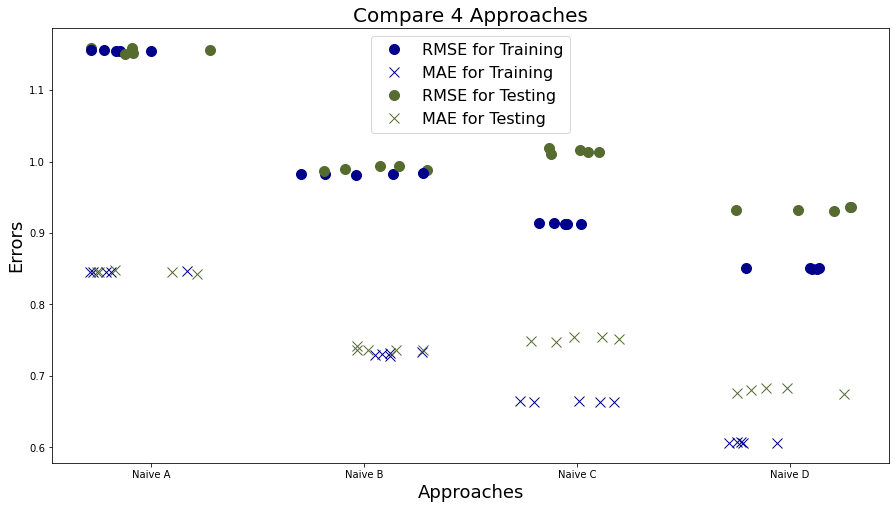

In [23]:
DF.to_pickle('Performance.pkl')
compare_vis(DF)   # visualizae the results

The Naive D approach works surprisingly well, and enhancement upon that is expected to be difficult and require a lot of techniques and modifications. One straightforward **extension** of the Naive D approach is to retain the **linear regression** structure and substitute **naive averages** with **mixed averages**.

# Mixed Averages

Unlike naive averages, **mixed averages** assumes that any rating is randomly drawn from the distribution of the ratings of that specific movie, and the average rating of one movie from the distribution of all average ratings (https://sifter.org/~simon/journal/20061211.html). Let the overall average and the overall variance of all movie ratings in the training set be $\mu$ and $\sigma^2$, and the average, variance, and number of ratings of the $j^{th}$ movies be $\mu_{(j)}$, $\sigma^2_{(j)}$, and $\tau_j$. Then **the mixed average** rating given to the $j^{th}$ movie can be computed as

$$\tilde{\mu}_{(j)} = \frac{\mu \cdot \frac{\sigma^2_{(j)}}{\sigma^2} + \mu_{(j)} \cdot \tau_j}{\frac{\sigma^2_{(j)}}{\sigma^2} + \tau_j}$$

Same logic applies to the mixed average rating given by the $i^{th}$ user. 

For computational convenience, training data will be represented as the **utility matrix**, $\mathbf{X}=(x_{i,j})$, where $x_{i,j}$ represents the rating given by the $i^{th}$ user to the $j^{th}$ movie. Note that $\mathbf{X}$ is very likely to be **sparse**, and missing/unknown values are represented by $-666$.

In [25]:
M = load(open("TrainingMatrix.p","rb"))

In [26]:
Mix = list()

for k in range(K):
    Mix.append(Mix_Averages(M[k], DATA.loc[Subsets[k],:]))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


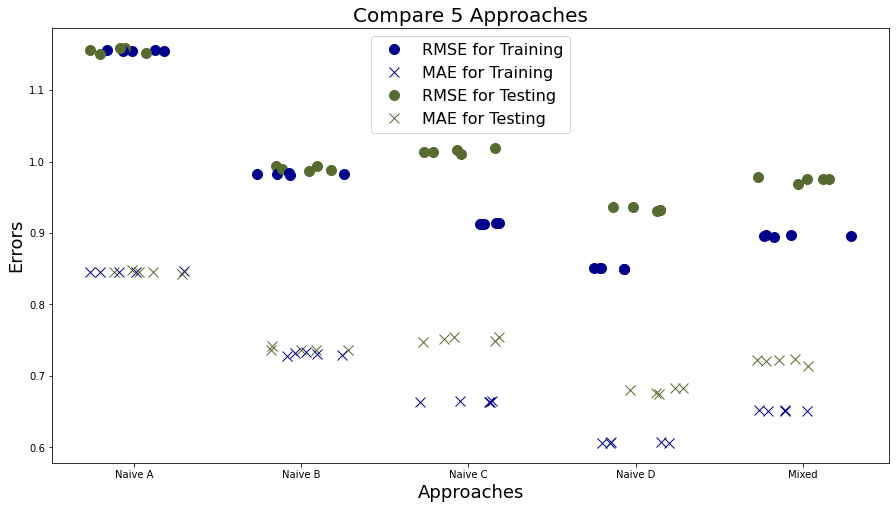

In [27]:
DF["Mixed"] = Mix
compare_vis(DF, title="MixedAverages.eps")

However, these more complicated averages do not bring about any improvement in the accuracy of prediction. We then turn to the Singular Value Decomposition (**SVD**) of the **utility matrix** $\mathbf{X}$ and use naive averages as **fallback values**.

# UV Matrix Decomposition

Suppose there are $m$ users and $n$ movies in the training set. It is quite time consuming to construct the utility matrix $\mathbf{X}_{m \times n}$ for each training set, so the outcomes have been stored in a dictionary: $k \rightarrow \mathbf{M}_{m(k) \times n(k)}, \; k = 1,2,3,4,5$, in which $\mathbf{M}$ is the **dataframe**, for the sake of prediction, converted from the utility matrix $\mathbf{X}$ with **User ID**s as the indexes and **Movie ID**s the columns. As it turns out, each training set covers all users and about $92\%$ of all movies in the dataset.

In [5]:
M = load(open("TrainingMatrix.p","rb"))

print("Sizes of Training Sets:")
for k in range(K):
    print("k =",k+1, "-->", M[k].shape)

Sizes of Training Sets:
k = 1 --> (610, 8975)
k = 2 --> (610, 8978)
k = 3 --> (610, 8979)
k = 4 --> (610, 8972)
k = 5 --> (610, 8956)


## Method

Decompose $\mathbf{X}$ into the product of $\mathbf{U}$ and $\mathbf{V}$ by minimizing the RMSE of $\mathbf{X}$ and $\mathbf{UV}$, only entries related to the known ratings taken into account. The **big idea** is to build up a model to predict the unknown entries of $\mathbf{X}$ with the corresponding entries of $\mathbf{UV}$, given that the known have been best explained. And the optimization is done by updating every $u_{i,q} \in \mathbf{U}, \; v_{q,j} \in \mathbf{V}$ so as to zeroize the partial derivatives respectively.

$$\mathbf{X}_{m \times n} \approx \mathbf{U}_{m \times d} \cdot \mathbf{V}_{d \times n}, \; d \leq min(m,n)$$

If a pair of user and movie from the **test set** has been included in the unknown of $X$, **predict** the rating with the corresponding entry of $\mathbf{UV}$; otherwise the prediction will be **the (naive) average** of the movie (or compromisingly, the user). If, not happening in this dataset, neither the user nor the movie has been included in $\mathbf{X}$, we have no way but to guess the average rating of all movies in the training set. To sum up, a dataframe is trained from the utility matrix, $\mathbf{X}$, of the training set, which consists of optimized $\mathbf{UV}$ plus a row of (naive) movie averages and a column of (naive) user avereges; then we make predictions for the test set from this dataframe.

## Exploratory Run

In [6]:
k = np.random.randint(0,K,size=1)[0]  # randomly pick a training set to explore

X = M[k].to_numpy(copy=True)
m,n = X.shape
TEST = DATA.loc[Subsets[k],:]
for d in range(1,3+int(np.sum(X> -100)/(m+n))):
    print("d =", d)
    t = process_time()
    # decompose 10 times to average out the randomness
    X_estimate = np.mean([estimate(X, d, drop=10) for t in range(10)], axis=0)
    print("Computation Time:", process_time()-t)
    print(Train(rmse(X,X_estimate),mae(X,X_estimate)))
    pred = Predict(df_predict(M[k], X_estimate), TEST)
    print(Test(RMSE(pred,TEST.rating),MAE(pred,TEST.rating)))
    print("")

d = 1
Computation Time: 95.3125
Train(RMSE=0.26725137786328984, MAE=0.027811907394255323)
Test(RMSE=2.229350125785527, MAE=1.898601745339151)

d = 2
Computation Time: 94.0
Train(RMSE=0.15089727168229797, MAE=0.014894566514617917)
Test(RMSE=1.2930412109384775, MAE=1.0201309004363348)

d = 3
Computation Time: 191.34375
Train(RMSE=0.13011933653923133, MAE=0.012686192606476831)
Test(RMSE=1.1656060421335124, MAE=0.9048988496628322)

d = 4
Computation Time: 256.71875
Train(RMSE=0.14602457816562248, MAE=0.014342230503957413)
Test(RMSE=1.2651501565755199, MAE=0.9974216580721936)

d = 5
Computation Time: 314.609375
Train(RMSE=0.13951061525041192, MAE=0.01375559200169863)
Test(RMSE=1.2256756671061626, MAE=0.964051963506545)

d = 6
Computation Time: 368.171875
Train(RMSE=0.15258883475524795, MAE=0.01515511169359858)
Test(RMSE=1.2995055966466578, MAE=1.0401626338754462)

d = 7
Computation Time: 433.375
Train(RMSE=0.1469312150306157, MAE=0.014530802685625174)
Test(RMSE=1.2686138884378204, MAE=1.004

In [30]:
print("Only", round(100*np.sum(X> -100)/(m*n),2), "% of the entries are nonblank.")

Only 1.47 % of the entries are nonblank.


Before running the algorithm on all data, randomly pick one of the training sets to explore. On one hand, the intuition is first to project the information of $n$ movies onto the space of $d$ features, and then to project features onto the space of $m$ users; the greater the number of features, the more precise the delineation. On the other hand, we tend to describe all valid ratings in $\mathbf{X}_{m \times n}$ with a smaller number of figures, $m \cdot d + d \cdot n$. Therefore, the plan is to set $d$ to be around $d^\star$.

$$d^\star = \max \{d \in \mathbb{Z} \; | \; (m+n)d \leq \#\{x_{i,j} \in \mathbf{X}|x_{i,j}>0 \} \}$$

**Findings of exploration: (i)** The computing time increases slower than linearly when $d$ grows from $1$ to $d^\star + 2$, and particularly, $d \approx d^\star$ is **computationally affordable**. **(ii)** Both RMSE and MAE for training are exceedingly small, while those for testing are significantly larger, suggesting **overfitting**, which is highly probable since over $98\%$ entries of $\mathbf{X}$ are blank.

## Experiment

Consequently, we will **(a)** let $d$ be $d^\star$ in modeling and take the average result of $10$ decompositions to cancel out the randomness; **(b)** drop the updating of $\mathbf{U}$ and $\mathbf{V}$ immediately after **one** iteration rather than ten.


In [6]:
random.seed(106)
UV = list()
t = process_time()
for k in range(K):
    UV.append( UV_approach(M[k], DATA.loc[Subsets[k],:], xi=1, repeat=10) )
T_uv = (process_time() - t)/K   

In [32]:
CT = [T_naive, T_uv]
dump(CT, open("ComputingTime.p","wb"))

In [14]:
DF = pd.read_pickle("Performance.pkl")
DF["UV"] = UV

,Naive A,Naive B,Naive C,Naive D,UV
k = 1,"((1.1546057038676178, 0.8446491217196197), (1....","((0.9812482774901456, 0.7279996033172594), (0....","((0.9119934977725566, 0.6633031275954828), (1....","((0.8504858521926035, 0.6065650993566302), (0....","((0.15455898793841064, 0.015251326544591076), ..."
k = 2,"((1.1563477164779463, 0.8461056911576937), (1....","((0.9828308924936712, 0.7335221708462978), (0....","((0.9138385219449098, 0.6644249959711909), (1....","((0.8494266401683, 0.6077613457461974), (0.931...","((0.16028730859916304, 0.0158453816067692), (1..."
k = 3,"((1.1553731031145793, 0.8451821641522765), (1....","((0.9823530632185838, 0.7296235232865165), (0....","((0.9135553060309782, 0.6650386145855285), (1....","((0.8504858521926035, 0.6065155140140575), (0....","((0.16110048602833582, 0.015936346922418267), ..."
k = 4,"((1.1547814994170764, 0.8451511733131686), (1....","((0.9829128728444183, 0.7304602759424315), (0....","((0.9122024596000878, 0.6636440268256704), (1....","((0.8496892873931984, 0.6058894990640766), (0....","((0.15586022787329448, 0.015361744735899678), ..."
k = 5,"((1.1566536739773337, 0.8452794168691427), (1....","((0.9834973665271228, 0.7323350027272276), (0....","((0.9132114891308568, 0.6638072097981852), (1....","((0.8508080857457034, 0.6079114394803392), (0....","((0.16283728001483017, 0.016234706653292227), ..."


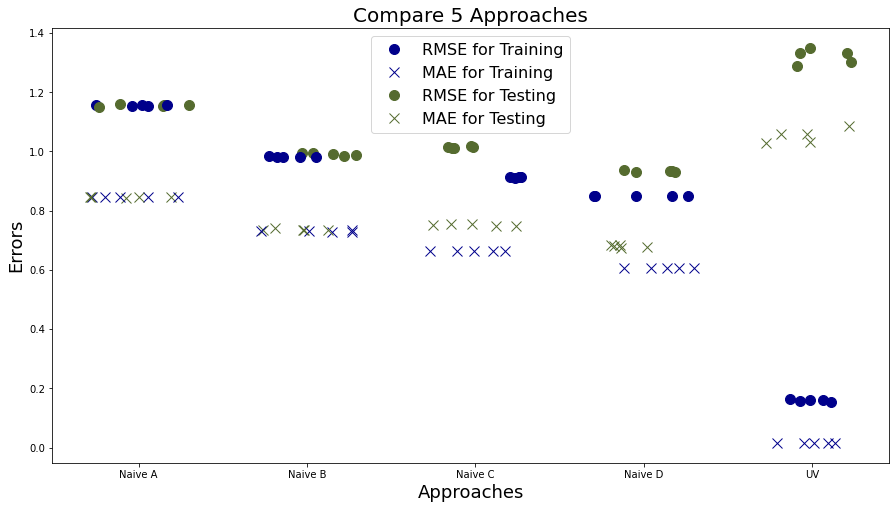

In [15]:
DF.to_pickle("Performance.pkl")  # save results
compare_vis(DF) # visualize the performances

To our disappointment, the training results still cannot generalize properly to the test set. The reasons could be **(i)** updating $\mathbf{U}$ and $\mathbf{V}$ by the root of every partial derivative is such a greedy optimization that even one iteration causes overfitting; **(ii)** $(\mathbf{UV})_{ij}$ are not accurate estimation for $x_{ij}$ in their own right. After all, it is implausible to make good inference from a rather small proportion of information. 

# Regularized Matrix Factorization combined with Naive Averages

## Method

$$\mathbf{X}_{m \times n} \approx \mathbf{W}_{m \times d} \cdot \mathbf{Z}_{d \times n}, \; d \approx d^\star$$

We now decide to integrate the naive averages, as they have proved reliable, and see SVD as a possible way to enhance the predictions to any degree. First, decompose $\mathbf{X}$ into $\mathbf{W}$ and $\mathbf{Z}$ by **gradient descent**, updating the $i^{th}$ row of $\mathbf{W}$ and the $j^{th}$ column of $\mathbf{Z}$ by a tiny step towards the opposite direction of the gradient of $\mathcal{B}(i,j)$ for every valid $x_{i,j}$, where $\lambda$ is the regularization term that controls overfitting and $\eta$ the learning rate specifying how greedy the optimization is. $(\mathbf{WZ})_{ij}$ is a possibly useful estimation of $x_{ij}$.

$$\mathcal{B}(i,j) = (x_{ij} - \vec{w}_{i,} \cdot \vec{z}_{,j})^2 + \frac{\lambda}{2} (\|\vec{w}_{i,}\|^2 + \|z_{,j}\|^2) = e_{ij}^2 + \frac{\lambda}{2}(\sum_{q=1}^{q=d}w^2_{iq}+\sum_{q=1}^{q=d}z^2_{qj})$$

$$\vec{w}_{i,} \leftarrow \vec{w}_{i,} - \eta \cdot \frac{\partial \mathcal{B}(i,j)}{\partial \vec{w}_{i,}} = \vec{w}_{i,} + \eta(2 e_{ij} \vec{z}^T_{,j} - \lambda \vec{w}_{i,})$$

$$\vec{z}_{,j} \leftarrow \vec{z}_{,j} - \eta \cdot \frac{\partial \mathcal{B}(i,j)}{\partial \vec{z}_{,j}} = \vec{z}_{,j} + \eta(2 e_{ij} \vec{w}^T_{i,} - \lambda \vec{z}_{,j})$$

Second, build a linear model that predicts a rating from the average rating given by the $i^{th}$ user, the average rating given to the $j^{th}$ movie, and the corresponding entry of $\mathbf{WZ}$. $\vec{\beta} = [\beta_0, \beta_1, \beta_2, \beta_3]^T$ is also estimated from the training set.

$$x_{ij} = \beta_0 + \beta_1 \mu_{(j)} + \beta_2 \mu^{(i)} + \beta_3 (\mathbf{WZ})_{ij}$$

## Exploratory Run

In [5]:
M = load(open("TrainingMatrix.p","rb"))

In [6]:
random.seed(37)
k = np.random.randint(0,K, size=1)[0]

X = M[k].to_numpy(copy=True)
TEST = DATA.loc[Subsets[k],:]
print("Matrix Factorization:")

# Matrix Factorization
t = process_time()
X_approx = np.mean([approx(X,d=10,lr=0.005,lam=0.05,drop=75) for run in range(10)], axis=0)  # decompose X=WZ
print(Train(rmse(X,X_approx),mae(X,X_approx)),"\n")   # training errors
pred = Predict(df_predict(M[k],X_approx), TEST)
print(Test(RMSE(pred,TEST.rating),MAE(pred,TEST.rating)),"\n")   # testing errors
print("Computing Time:", process_time()-t)

Matrix Factorization:
Train(RMSE=0.14591807485733793, MAE=0.014369752043472284) 

Test(RMSE=1.185219547640641, MAE=0.9279020181484604) 

Computing Time: 2339.03125


In [7]:
# try to improve from previous results
t = process_time()
beta,train_errors = linear_model(X, X_approx)    # learn coefficients by linear regression
print("Regression Coefficients:", beta)
print(train_errors, "\n")       # new training errors
pred = Predict_comb(df_predict(M[k],X_approx), TEST, beta)   # new prediction
print(Test(RMSE(pred,TEST.rating), MAE(pred,TEST.rating)), "\n")    # new testing errors
print("Computing Time:", process_time()-t)

Regression Coefficients: [-1.0651476   0.71897929  0.54250894  0.04302553]
Train(RMSE=0.8928791283731754, MAE=0.6490473416058213) 

Test(RMSE=0.9742939868168939, MAE=0.7224673972331036) 

Computing Time: 2.84375


Again, randomly pick a training set to explore. **Overfitting** still seems to be a problem when predicting $x_{ij}$ with $(\mathbf{WZ})_{ij}$, but could be ameliorated by the involvement of naive averages. The linear combination of matrix factorization and naive averages prove to be an improved prediction.

## Experiment

Let $d=10$, $\lambda=0.05$, $\eta=0.005$, and the max number of iterations in optimization $\xi=75$. Take the average result of $10$ factorizations of $\mathbf{X}$ and compute the training and the testing errors.

In [8]:
# try arbitrary hyperparameters
lbd = 0.05
num_iter = 75
num_features = 10
eta = 0.005

COMB = list()
t = process_time()

random.seed(61)
for k in range(K):
    res = Comb_approach(M[k], DATA.loc[Subsets[k],:], num_features, eta, lbd, xi=num_iter, repeat=10)
    COMB.append(res)   

T_comb = (process_time() - t)/K

In [15]:
CT = load(open("ComputingTime.p","rb"))
CT.append(T_comb)
dump(CT, open("ComputingTime.p","wb"))

In [22]:
DF = pd.read_pickle("Performance.pkl")
DF["Combined"] = COMB

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


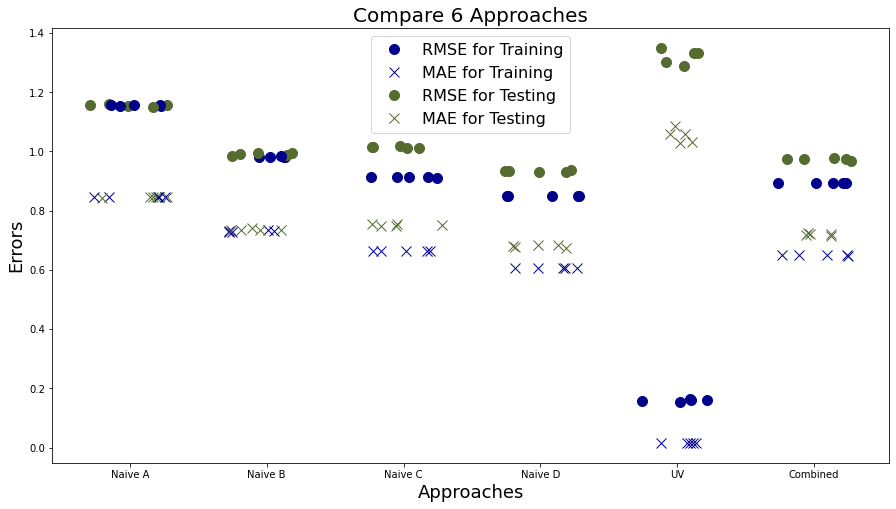

In [23]:
DF.to_pickle("Performance.pkl")
compare_vis(DF, title="Performance.eps")

Despite the computational cost, this combined approach does not manage to outperform the linear model of naive averages; rather, adding the result of regularized matrix factorization slightly pulls up the errors of prediction. However, the performance might possibly be enhanced by fine-tuning the hyperparameters.

## Hyperparameters

The outcome of matrix factorization, $\mathbf{X} \approx \mathbf{WZ}$, is subject to  four **hyperparameters**, namely, $d, \lambda, \eta$, and $\xi$. Since small $\eta$ combined with more iterations and large $\eta$ with fewer iterations function similarly as long as the gradients do not explode, and judging from the previous behaviors of SVD, $d$ makes little difference when $d \approx d^\star$, let $d=10, \eta = 0.005$, and investigate the better choice of $\lambda$ and $\xi$ in a grid manner. In each run, report the RMSE for both training and testing.

In [10]:
random.seed(179)
k = np.random.randint(0,K,size=1)[0] # randomly pick a training set to experiment

X = M[k].to_numpy(copy=True)
TEST = DATA.loc[Subsets[k],:]

H = dict()
penalty = [0.01, 0.05, 0.1]
num_iter = [50, 75, 100]
num_features = 10
eta = 0.005

for lbd in penalty:
    lst = list()
    for xi in num_iter:
        a,b = Comb_approach(M[k], DATA.loc[Subsets[k],:], num_features, eta, lbd, xi, repeat=10)
        lst.append((a.RMSE,b.RMSE))
    H[lbd] = lst
    
H = pd.DataFrame(H,index=[r"$\xi$ = "+str(ele) for ele in num_iter])
H.columns = [r"$\lambda$ = "+str(ele) for ele in penalty]

In [12]:
H.to_pickle("Hyperparameters.pkl")  # save results
H

,$\lambda$ = 0.01,$\lambda$ = 0.05,$\lambda$ = 0.1
$\xi$ = 50,"(0.8917051963293381, 0.9689097665759959)","(0.8918511536177156, 0.9673219766015981)","(0.8917538514131832, 0.9665527547416725)"
$\xi$ = 75,"(0.8937394942063354, 0.9674501207828274)","(0.8935314171504551, 0.9669887222569263)","(0.8935452904616459, 0.967347606795861)"
$\xi$ = 100,"(0.8936562691977704, 0.9658085912530834)","(0.8925458608797469, 0.966013934990754)","(0.8960874071692089, 0.9661679141535711)"


Unfortunately, in the limited scope of grid search, $\{0.01, 0.05, 0.1\} \times \{50, 75, 100\}$, we cannot find a $(\lambda, \xi)$ that improves the estimation of a randomly picked utility matrix to a significant extent.There could be an optimal choice beyond this scope, but the search is computationally expensive.

# Compare

In [24]:
DF = add_avg(pd.read_pickle("Performance.pkl"))  # add a row of average scores of each approach to the dataframe

In [25]:
AVERAGE = dict()
AVERAGE["Computing Time"] = load(open("ComputingTime.p","rb"))
AVERAGE["RMSE Training"] = [a.RMSE for a,b in DF.loc["Average",]][-3:]
AVERAGE["RMSE Test"] = [b.RMSE for a,b in DF.loc["Average",]][-3:]
AVERAGE["MAE Training"] = [a.MAE for a,b in DF.loc["Average",]][-3:]
AVERAGE["MAE Test"] = [b.MAE for a,b in DF.loc["Average",]][-3:]

AVERAGE = pd.DataFrame(AVERAGE, index=DF.columns[-3:]).transpose()

In [27]:
AVERAGE.to_pickle("AVERAGE.pkl")
AVERAGE

,Naive D,UV,Combined
Computing Time,5.406250,58.487500,2364.215625
RMSE Training,0.850179,0.158929,0.893113
RMSE Test,0.933421,1.321096,0.973641
MAE Training,0.606929,0.015726,0.649495
MAE Test,0.679053,1.053116,0.719862


So far the linear model on the movie averages and user averages of ratings in the training set has excelled in both **computing time** and **prediction accuracy**. Methods that employ SVD are less reliable as hand-crafted hyperparameters are involved, but the performance can be optimized by fine-tuning hyperparameters.

In [29]:
AVERAGE.to_latex(float_format="%.4f")

'\\begin{tabular}{lrrr}\n\\toprule\n{} &  Naive D &      UV &  Combined \\\\\n\\midrule\nComputing Time &   5.4062 & 58.4875 & 2364.2156 \\\\\nRMSE Training  &   0.8502 &  0.1589 &    0.8931 \\\\\nRMSE Test      &   0.9334 &  1.3211 &    0.9736 \\\\\nMAE Training   &   0.6069 &  0.0157 &    0.6495 \\\\\nMAE Test       &   0.6791 &  1.0531 &    0.7199 \\\\\n\\bottomrule\n\\end{tabular}\n'